# Attention-Weighted

## Initialization

In [3]:
import random
import torch
import warnings
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from visionts import VisionTS
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from visionts.models_mae import MaskedAutoencoderViT
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Section 1: MAE Model with Attention-Weighted Bivariate Encoding


### Helper Functions

In [4]:
def bivariate_attention_weighted_image(series1, series2, context_len, pred_len, periodicity=24):
    """
    BiViSION Attention-Weighted Fusion Method:
    - Red Channel: Variable 1 (Traffic)
    - Green Channel: Variable 2 (Users)
    - Blue Channel: Correlation-weighted adaptive fusion
    
    The attention weight is computed based on the correlation between variables.
    """
    total_len = context_len + pred_len
    # Truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization later
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Compute global correlation coefficient
    corr = np.corrcoef(series1[:usable_len], series2[:usable_len])[0, 1]
    # Normalize correlation to [0, 1] range for alpha weight
    alpha = (corr + 1) / 2  # Maps [-1, 1] to [0, 1]
    
    print(f"📊 Correlation between Traffic and Users: {corr:.4f}")
    print(f"🎯 Attention weight (alpha): {alpha:.4f}")
    
    # Create blue channel as correlation-weighted adaptive fusion
    # When correlation is high (alpha → 1), more weight on series1
    # When correlation is low (alpha → 0.5), balanced weight
    # When negative correlation (alpha → 0), more weight on series2
    matrix_fusion = alpha * matrix1_norm + (1 - alpha) * matrix2_norm
    
    # Convert to uint8 [0, 255]
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix_fusion * 255).astype(np.uint8)
    
    # Stack into RGB image
    height, width = r_channel.shape
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and normalization parameters
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len,
        'alpha': alpha,
        'correlation': corr
    }
    
    return img, norm_params

def attention_weighted_image_to_bivariate(img, norm_params, periodicity=24):
    """
    Decode attention-weighted RGB image back to two time series
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Extract channels
    r_channel = img_array[:, :, 0]  # Traffic
    g_channel = img_array[:, :, 1]  # Users
    # Blue channel contains fusion but we only need original variables
    
    # Flatten
    series1_norm = r_channel.flatten()
    series2_norm = g_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

### Execution

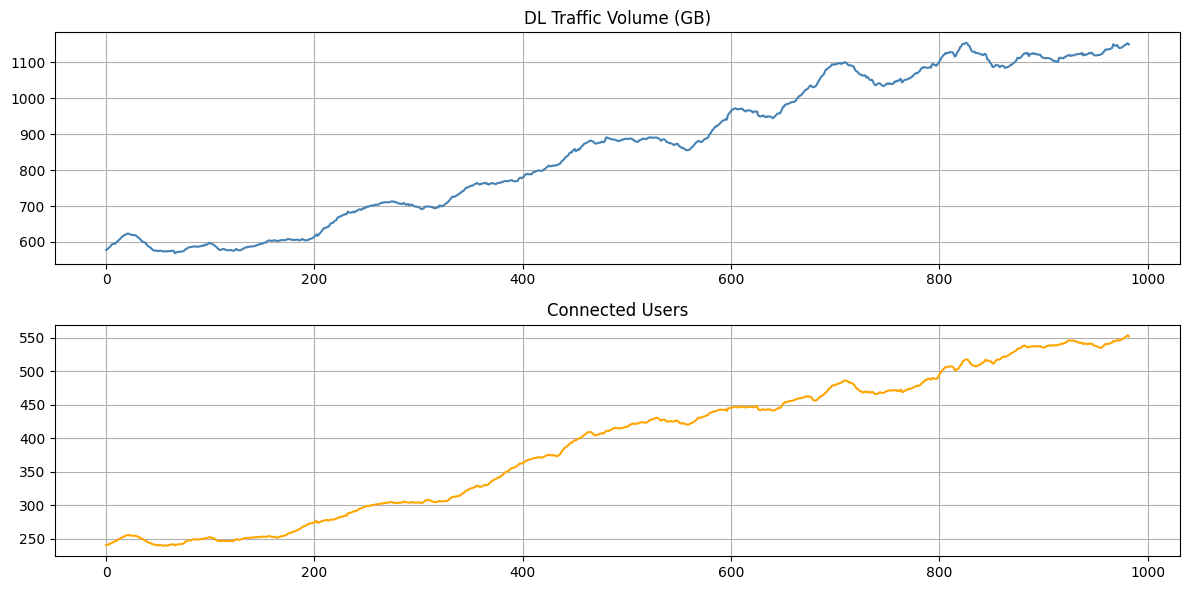

📊 Correlation between Traffic and Users: 0.9894
🎯 Attention weight (alpha): 0.9947


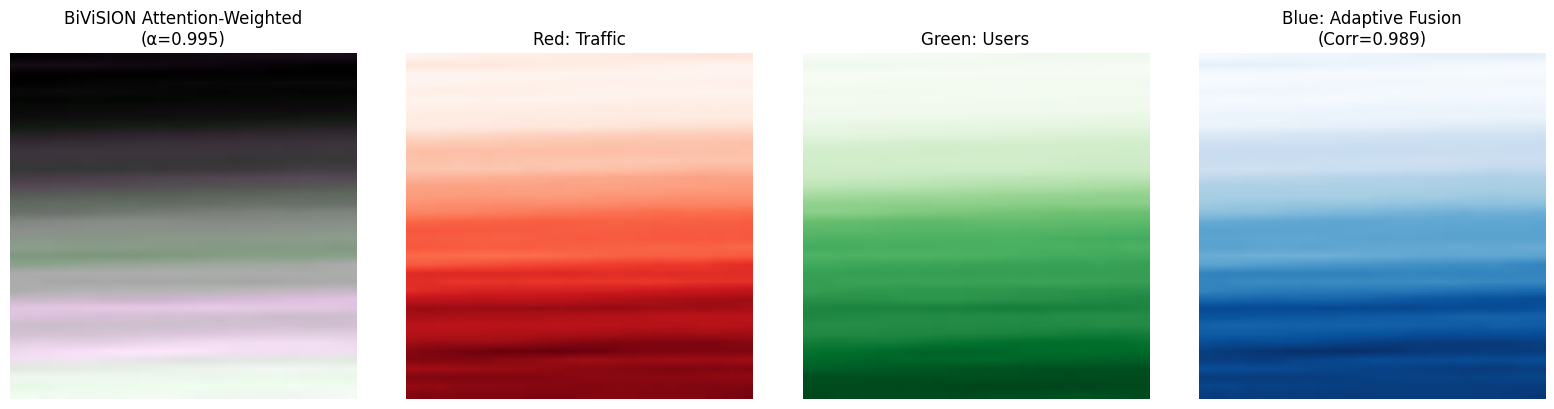

In [ ]:
# STEP 0: Configurable forecast length
PRED_LEN         = 100  # CHANGE THIS ONLY
PLOT_CONTEXT_LEN = 300  # Only change this to zoom in or out

# Step 2: Load from CSV - BIVARIATE DATA
df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')

CONTEXT_LEN = len(df) - PRED_LEN

# Extract both variables (bivariate)
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]
data_users = df['connected_users'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]

# Plot both variables
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(data_traffic, color='steelblue')
axs[0].set_title("DL Traffic Volume (GB)")
axs[0].grid(True)

axs[1].plot(data_users, color='orange')
axs[1].set_title("Connected Users")
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Step 3: Convert BIVARIATE time series to RGB image using Attention-Weighted Fusion
img, norm_params = bivariate_attention_weighted_image(data_traffic, data_users, CONTEXT_LEN, PRED_LEN)

# Visualize the RGB encoding
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Full RGB
axes[0].imshow(img)
axes[0].set_title(f"BiViSION Attention-Weighted\n(α={norm_params['alpha']:.3f})")
axes[0].axis('off')

# Individual channels
img_array = np.array(img)
axes[1].imshow(img_array[:, :, 0], cmap='Reds')
axes[1].set_title("Red: Traffic")
axes[1].axis('off')

axes[2].imshow(img_array[:, :, 1], cmap='Greens')
axes[2].set_title("Green: Users")
axes[2].axis('off')

axes[3].imshow(img_array[:, :, 2], cmap='Blues')
axes[3].set_title(f"Blue: Adaptive Fusion\n(Corr={norm_params['correlation']:.3f})")
axes[3].axis('off')

plt.tight_layout()
plt.show()

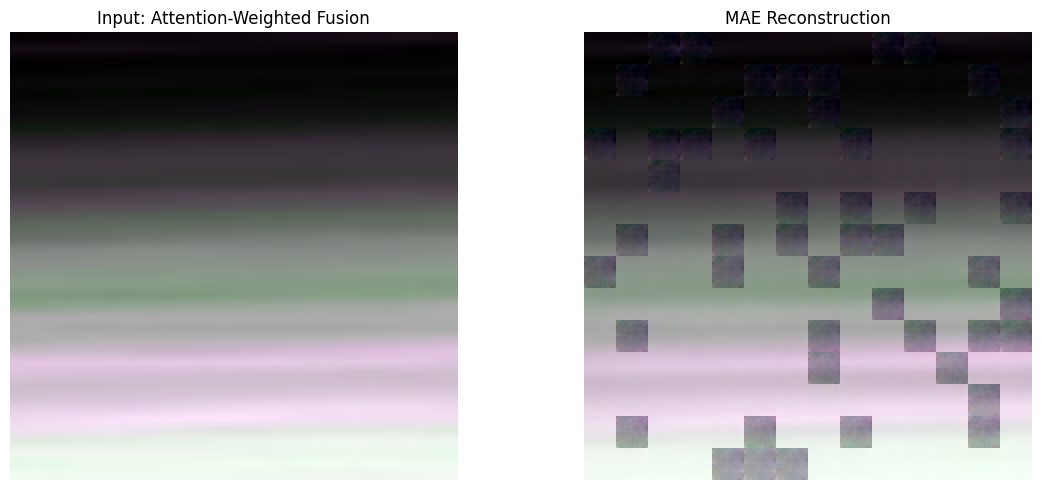

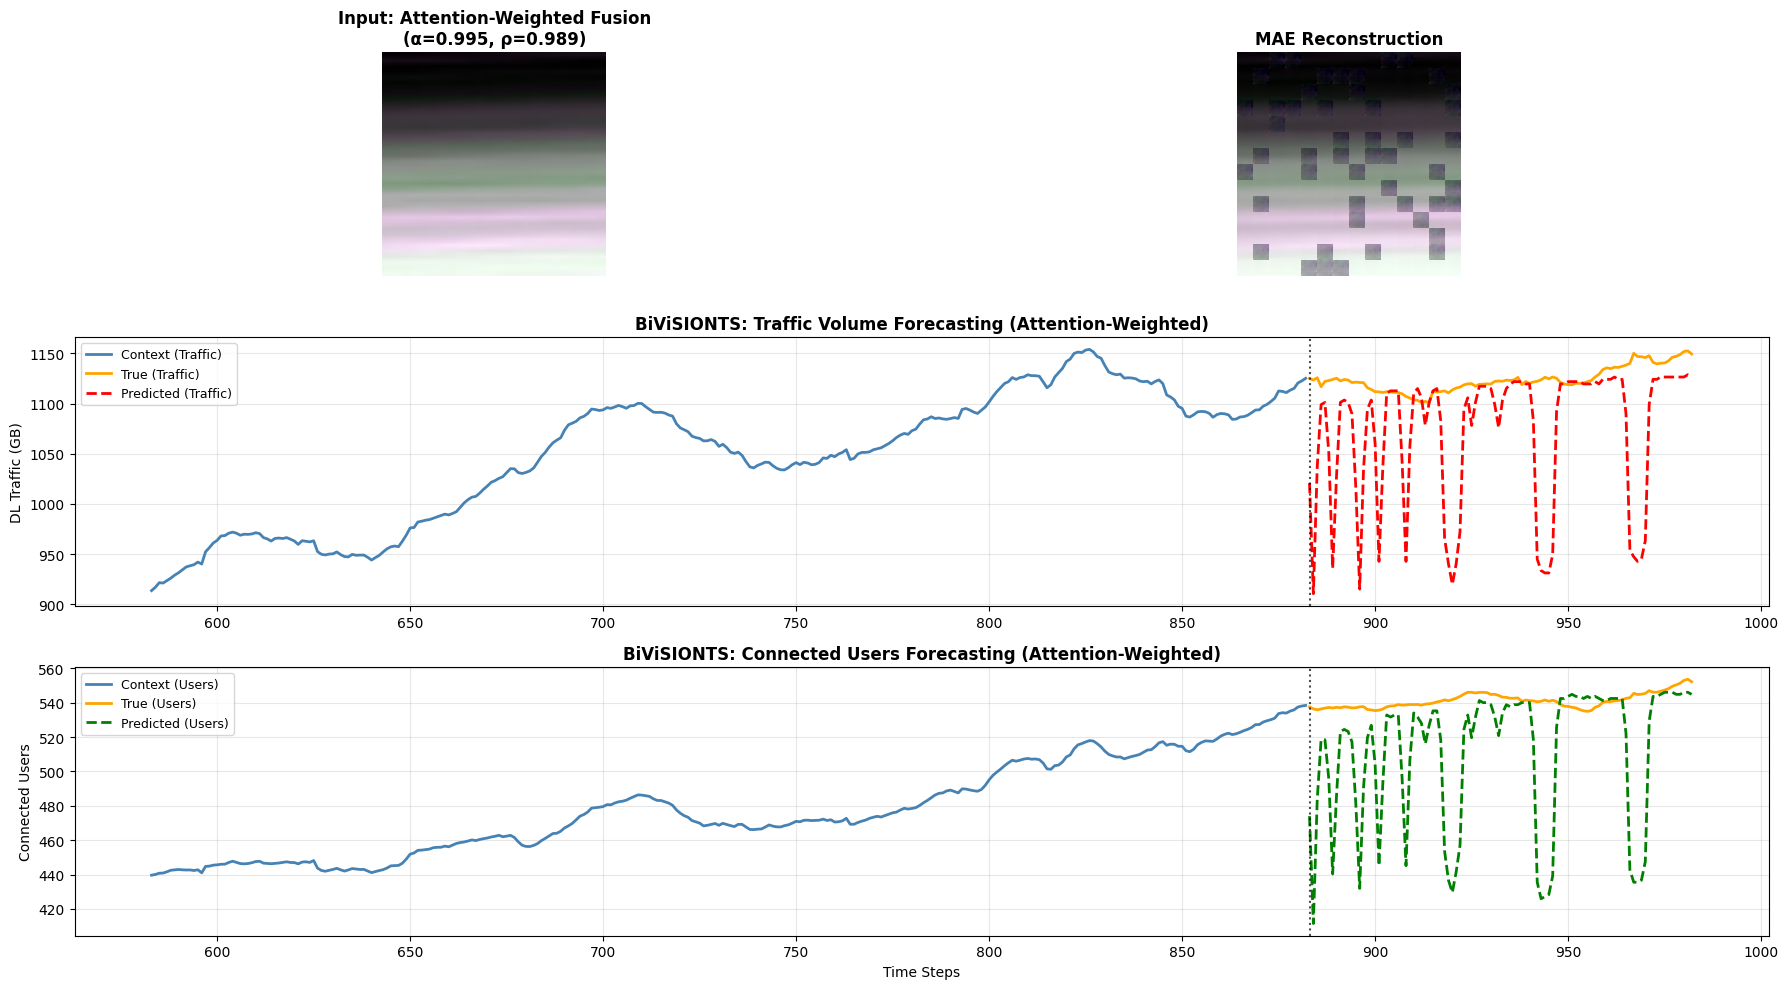

📊 BiViSIONTS Evaluation - MAE Model (Attention-Weighted Fusion)

🎯 Attention Parameters:
  Correlation (ρ) = 0.9894
  Attention weight (α) = 0.9947

🔴 DL Traffic Volume:
  MSE  = 7740.3207
  MAE  = 54.2409
  RMSE = 87.9791
  ✅ Success Rate (±10%): 80.00%

🟢 Connected Users:
  MSE  = 2483.8291
  MAE  = 31.3807
  RMSE = 49.8380
  ✅ Success Rate (±10%): 78.00%


In [ ]:
# Step 4: Run MAE reconstruction on BIVARIATE attention-weighted image
model = MaskedAutoencoderViT(
    img_size         =224, patch_size   =16, in_chans         =3 ,
    embed_dim        =768, depth        =12, num_heads        =12,
    decoder_embed_dim=512, decoder_depth=8 , decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model'], strict=False)
model.eval()

x = ToTensor()(img).unsqueeze(0)
with torch.no_grad():
    latent, mask, ids_restore = model.forward_encoder(x, mask_ratio=0.75)
    pred = model.forward_decoder(latent, ids_restore)
    output = model.unpatchify(pred).squeeze().permute(1, 2, 0).numpy()

output = np.clip(output * 255, 0, 255).astype(np.uint8)
reconstructed_img = Image.fromarray(output, mode='RGB')

# Visualize reconstruction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img)
axes[0].set_title("Input: Attention-Weighted Fusion")
axes[0].axis('off')

axes[1].imshow(reconstructed_img)
axes[1].set_title("MAE Reconstruction")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Step 5: Decode BIVARIATE forecasts from reconstructed attention-weighted image
# Decode reconstructed image
recon_traffic, recon_users = attention_weighted_image_to_bivariate(reconstructed_img, norm_params)

# Extract forecast portions
forecast_traffic = recon_traffic[-PRED_LEN:]
forecast_users = recon_users[-PRED_LEN:]

# Ground truth
true_traffic = data_traffic[:CONTEXT_LEN + PRED_LEN]
true_users = data_users[:CONTEXT_LEN + PRED_LEN]

# --- Visualization ---
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1.2, 1.2])

# Row 1: Images
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img)
ax1.set_title(f"Input: Attention-Weighted Fusion\n(α={norm_params['alpha']:.3f}, ρ={norm_params['correlation']:.3f})", fontsize=12, fontweight='bold')
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(reconstructed_img)
ax2.set_title("MAE Reconstruction", fontsize=12, fontweight='bold')
ax2.axis("off")

# Row 2: Traffic forecasting
ax3 = fig.add_subplot(gs[1, :])
plot_start = max(0, CONTEXT_LEN - PLOT_CONTEXT_LEN)
ax3.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_traffic[plot_start:CONTEXT_LEN],
    label="Context (Traffic)", color="steelblue", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Traffic)", color="orange", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_traffic, label="Predicted (Traffic)", color="red", linewidth=2, linestyle='--'
)
ax3.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax3.set_title("BiViSIONTS: Traffic Volume Forecasting (Attention-Weighted)", fontsize=12, fontweight='bold')
ax3.set_ylabel("DL Traffic (GB)", fontsize=10)
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# Row 3: Users forecasting
ax4 = fig.add_subplot(gs[2, :])
ax4.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_users[plot_start:CONTEXT_LEN],
    label="Context (Users)", color="steelblue", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Users)", color="orange", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_users, label="Predicted (Users)", color="green", linewidth=2, linestyle='--'
)
ax4.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax4.set_title("BiViSIONTS: Connected Users Forecasting (Attention-Weighted)", fontsize=12, fontweight='bold')
ax4.set_xlabel("Time Steps", fontsize=10)
ax4.set_ylabel("Connected Users", fontsize=10)
ax4.legend(loc='best', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Evaluation Metrics ---
true_traffic_forecast = true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
true_users_forecast = true_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Traffic metrics
mse_traffic = mean_squared_error(true_traffic_forecast, forecast_traffic)
mae_traffic = mean_absolute_error(true_traffic_forecast, forecast_traffic)
rmse_traffic = np.sqrt(mse_traffic)

# Users metrics
mse_users = mean_squared_error(true_users_forecast, forecast_users)
mae_users = mean_absolute_error(true_users_forecast, forecast_users)
rmse_users = np.sqrt(mse_users)

# Success rates (±10% tolerance)
tolerance = 0.10
success_traffic = (np.abs(forecast_traffic - true_traffic_forecast) <= tolerance * np.abs(true_traffic_forecast)).sum() / len(true_traffic_forecast)
success_users = (np.abs(forecast_users - true_users_forecast) <= tolerance * np.abs(true_users_forecast)).sum() / len(true_users_forecast)

# Print results
print("=" * 80)
print("📊 BiViSIONTS Evaluation - MAE Model (Attention-Weighted Fusion)")
print("=" * 80)
print(f"\n🎯 Attention Parameters:")
print(f"  Correlation (ρ) = {norm_params['correlation']:.4f}")
print(f"  Attention weight (α) = {norm_params['alpha']:.4f}")

print(f"\n🔴 DL Traffic Volume:")
print(f"  MSE  = {mse_traffic:.4f}")
print(f"  MAE  = {mae_traffic:.4f}")
print(f"  RMSE = {rmse_traffic:.4f}")
print(f"  ✅ Success Rate (±10%): {success_traffic * 100:.2f}%")

print(f"\n🟢 Connected Users:")
print(f"  MSE  = {mse_users:.4f}")
print(f"  MAE  = {mae_users:.4f}")
print(f"  RMSE = {rmse_users:.4f}")
print(f"  ✅ Success Rate (±10%): {success_users * 100:.2f}%")
print("=" * 80)

## Section 2: BiViSIONTS Model with Attention-Weighted Bivariate Encoding


### Helper Functions

In [ ]:
# ========================================================================
# Common
# ========================================================================

def bivariate_multiscale_attention(series1, series2, periodicity=24, short_window=100, medium_window=300):
    """
    Multi-Scale Attention-Weighted Encoding Function
    BiViSION Multi-Scale Attention-Weighted Fusion
    Computes attention weights at multiple temporal scales
    """
    total_len = len(series1)
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Compute correlations at multiple scales
    # 1. Long-term (global) correlation
    corr_long = np.corrcoef(series1[:usable_len], series2[:usable_len])[0, 1]
    alpha_long = (corr_long + 1) / 2
    
    # 2. Medium-term correlation (last medium_window points)
    if usable_len > medium_window:
        corr_medium = np.corrcoef(
            series1[usable_len-medium_window:usable_len], 
            series2[usable_len-medium_window:usable_len]
        )[0, 1]
        alpha_medium = (corr_medium + 1) / 2
    else:
        corr_medium = corr_long
        alpha_medium = alpha_long
    
    # 3. Short-term correlation (last short_window points)
    if usable_len > short_window:
        corr_short = np.corrcoef(
            series1[usable_len-short_window:usable_len], 
            series2[usable_len-short_window:usable_len]
        )[0, 1]
        alpha_short = (corr_short + 1) / 2
    else:
        corr_short = corr_long
        alpha_short = alpha_long
    
    # Weighted combination of attention weights
    # Give more weight to recent correlations
    w_short = 0.5   # Most weight to recent patterns
    w_medium = 0.3  # Medium weight to medium-term
    w_long = 0.2    # Least weight to long-term
    
    alpha_final = w_short * alpha_short + w_medium * alpha_medium + w_long * alpha_long
    
    print(f"📊 Multi-Scale Correlations:")
    print(f"  Short-term (last {short_window}): ρ={corr_short:.4f}, α={alpha_short:.4f} (weight: 0.5)")
    print(f"  Medium-term (last {medium_window}): ρ={corr_medium:.4f}, α={alpha_medium:.4f} (weight: 0.3)")
    print(f"  Long-term (full): ρ={corr_long:.4f}, α={alpha_long:.4f} (weight: 0.2)")
    print(f"  ⚡ Final Attention α: {alpha_final:.4f}")
    
    # Create blue channel as multi-scale adaptive fusion
    matrix_fusion = alpha_final * matrix1_norm + (1 - alpha_final) * matrix2_norm
    
    # Convert to uint8 [0, 255]
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix_fusion * 255).astype(np.uint8)
    
    # Stack into RGB image
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and parameters
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len,
        'alpha_final': alpha_final,
        'alpha_short': alpha_short,
        'alpha_medium': alpha_medium,
        'alpha_long': alpha_long,
        'corr_short': corr_short,
        'corr_medium': corr_medium,
        'corr_long': corr_long
    }
    
    return img, norm_params

def multiscale_attention_to_bivariate(img, norm_params, periodicity=24):
    """
    Decode both variables from reconstruction
    Decode multi-scale attention-weighted RGB image back to two time series
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Extract channels
    r_channel = img_array[:, :, 0]  # Traffic
    g_channel = img_array[:, :, 1]  # Users
    
    # Flatten
    series1_norm = r_channel.flatten()
    series2_norm = g_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

def initialize_models_and_data(data_traffic, data_users, context_len, pred_len, device):
    """Initialize models and prepare data"""
    
    # Initialize VisionTS model
    model = VisionTS('mae_base', './ckpt/').to(device)
    model.update_config(
        context_len =context_len,
        pred_len    =pred_len,
        align_const =1,
        norm_const  =1,
        periodicity =24
    )
    model.eval()
    
    # Initialize MAE model
    mae_model = MaskedAutoencoderViT(
        img_size         =224, patch_size   =16, in_chans         =3 ,
        embed_dim        =768, depth        =12, num_heads        =12,
        decoder_embed_dim=512, decoder_depth=8 , decoder_num_heads=16
    )
    
    # Load pretrained weights
    ckpt_path = './ckpt/mae_visualize_vit_base.pth'
    ckpt = torch.load(ckpt_path, map_location='cpu')
    mae_model.load_state_dict(ckpt['model'], strict=False)
    mae_model.eval()
    mae_model.to(device)
    
    # Prepare full series
    full_traffic = data_traffic[:context_len + pred_len]
    full_users   = data_users  [:context_len + pred_len]
    
    return model, mae_model, full_traffic, full_users


# ========================================================================
# Single Run
# ========================================================================

def run_bivisionts_multiscale_forecast(
    data_traffic, 
    data_users, 
    mae_model, 
    context_len, 
    pred_len,
    mask_ratio,
    periodicity,
    short_window,
    medium_window,
    device,
    random_seed = 42
):
    """
    Run BiViSIONTS multi-scale attention forecast
    
    Returns:
        dict: Contains forecasts, metrics, images, and parameters
    """
    # # Set random seed
    # random.seed(random_seed)
    # np.random.seed(random_seed)
    # torch.manual_seed(random_seed)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed_all(random_seed)
    
    # Prepare full series
    full_traffic = data_traffic[:context_len + pred_len]
    full_users   = data_users  [:context_len + pred_len]
    
    # Create multi-scale attention-weighted image
    input_img, norm_params = bivariate_multiscale_attention(
        full_traffic, full_users,
        periodicity  =periodicity  ,
        short_window =short_window ,
        medium_window=medium_window
    )
    
    # Convert to tensor
    x_tensor = ToTensor()(input_img).unsqueeze(0).to(device)
    
    # Run MAE forward pass
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=mask_ratio)
        pred = mae_model.forward_decoder(latent, ids_restore)
        recon_tensor = mae_model.unpatchify(pred)
    
    # Convert reconstruction back to image
    recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_rgb, mode='RGB')
    
    # Decode reconstructed image
    recon_traffic_full, recon_users_full = multiscale_attention_to_bivariate(
        recon_img, norm_params, periodicity=periodicity
    )
    
    # Extract forecast portions
    forecast_traffic = recon_traffic_full[-pred_len:]
    forecast_users   = recon_users_full  [-pred_len:]
    
    # Ground truth
    y_traffic = data_traffic[context_len:context_len + pred_len]
    y_users   = data_users  [context_len:context_len + pred_len]
    
    # Calculate metrics
    mse_traffic = mean_squared_error(y_traffic, forecast_traffic)
    mae_traffic = mean_absolute_error(y_traffic, forecast_traffic)
    rmse_traffic = np.sqrt(mse_traffic)
    success_traffic = (np.abs(forecast_traffic - y_traffic) <= 0.10 * np.abs(y_traffic)).sum() / len(y_traffic)
    
    mse_users = mean_squared_error(y_users, forecast_users)
    mae_users = mean_absolute_error(y_users, forecast_users)
    rmse_users = np.sqrt(mse_users)
    success_users = (np.abs(forecast_users - y_users) <= 0.10 * np.abs(y_users)).sum() / len(y_users)
    
    # Return results
    return {
        'input_img': input_img,
        'recon_img': recon_img,
        'norm_params': norm_params,
        'forecast_traffic': forecast_traffic,
        'forecast_users': forecast_users,
        'y_traffic': y_traffic,
        'y_users': y_users,
        'metrics': {
            'traffic': {
                'mse': mse_traffic,
                'mae': mae_traffic,
                'rmse': rmse_traffic,
                'success_rate': success_traffic * 100
            },
            'users': {
                'mse': mse_users,
                'mae': mae_users,
                'rmse': rmse_users,
                'success_rate': success_users * 100
            }
        }
    }

def visualize_multiscale_encoding(input_img, norm_params):
    """Visualize multi-scale attention encoding"""
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Panel 1: Full RGB image
    axes[0].imshow(input_img)
    axes[0].set_title(f"Multi-Scale Attention\n(α={norm_params['alpha_final']:.3f})", fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    # Panel 2: Red channel (Traffic)
    img_array = np.array(input_img)
    axes[1].imshow(img_array[:, :, 0], cmap='Reds')
    axes[1].set_title("Red: Traffic", fontsize=10)
    axes[1].axis('off')
    
    # Panel 3: Green channel (Users)
    axes[2].imshow(img_array[:, :, 1], cmap='Greens')
    axes[2].set_title("Green: Users", fontsize=10)
    axes[2].axis('off')
    
    # Panel 4: Blue channel (Adaptive Fusion)
    axes[3].imshow(img_array[:, :, 2], cmap='Blues')
    axes[3].set_title(f"Blue: Adaptive Fusion\n(α={norm_params['alpha_final']:.3f})", fontsize=10)
    axes[3].axis('off')
    
    # Panel 5: Multi-scale attention weights bar chart
    scales = ['Short\n(100)', 'Medium\n(300)', 'Long\n(Full)']
    alphas = [norm_params['alpha_short'], norm_params['alpha_medium'], norm_params['alpha_long']]
    colors_bar = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    
    axes[4].bar(scales, alphas, color=colors_bar, alpha=0.7, edgecolor='black')
    axes[4].axhline(y=norm_params['alpha_final'], color='red', linestyle='--', linewidth=2, label=f"Final α={norm_params['alpha_final']:.3f}")
    axes[4].set_ylabel('Attention Weight (α)', fontsize=10)
    axes[4].set_title('Multi-Scale Attention', fontsize=10, fontweight='bold')
    axes[4].set_ylim([0, 1])
    axes[4].legend(loc='upper right', fontsize=8)
    axes[4].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def visualize_forecast_results(result, df, context_len, pred_len, plot_context_len=300, title_suffix=""):
    """Visualize forecast results with images and time series"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Top-left: Input image
    axes[0, 0].imshow(result['input_img'])
    axes[0, 0].set_title(
        f"Input: Multi-Scale Attention Fusion{title_suffix}\n(α_final={result['norm_params']['alpha_final']:.3f})", 
        fontsize=12, fontweight='bold'
    )
    axes[0, 0].axis('off')
    
    # Top-right: Reconstructed image
    axes[0, 1].imshow(result['recon_img'])
    axes[0, 1].set_title(f"MAE Reconstruction{title_suffix}", fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Prepare timestamps for time series
    timestamps = pd.to_datetime(df['date'])
    time_x = timestamps[:context_len]
    time_y = timestamps[context_len:context_len + pred_len]
    
    x_traffic = data_traffic[:context_len]
    x_users = data_users[:context_len]
    
    # Bottom-left: Traffic forecasting
    axes[1, 0].plot(time_x[-plot_context_len:], x_traffic[-plot_context_len:], label="Context", color='steelblue', linewidth=2)
    axes[1, 0].plot(time_y, result['y_traffic'], label="True", color='orange', linewidth=2)
    axes[1, 0].plot(time_y, result['forecast_traffic'], label="Predicted", color='red', linewidth=2, linestyle='--')
    axes[1, 0].set_title(f"BiViSIONTS{title_suffix}: Traffic Volume Forecasting", fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel("DL Traffic (GB)")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Bottom-right: Users forecasting
    axes[1, 1].plot(time_x[-plot_context_len:], x_users[-plot_context_len:], label="Context", color='steelblue', linewidth=2)
    axes[1, 1].plot(time_y, result['y_users'], label="True", color='orange', linewidth=2)
    axes[1, 1].plot(time_y, result['forecast_users'], label="Predicted", color='green', linewidth=2, linestyle='--')
    axes[1, 1].set_title(f"BiViSIONTS{title_suffix}: Connected Users Forecasting", fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel("Connected Users")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

def print_metrics(result, hyperparams=None, title="BiViSIONTS Evaluation"):
    """Print evaluation metrics"""
    print("=" * 80)
    print(f"📊 {title}")
    print("=" * 80)
    
    # Print hyperparameters if provided
    if hyperparams:
        print(f"\n🏆 Hyperparameters:")
        for key, value in hyperparams.items():
            print(f"  {key}: {value}")
    
    # Print multi-scale attention parameters
    norm_params = result['norm_params']
    print(f"\n🎯 Multi-Scale Attention Parameters:")
    print(f"  Short-term: ρ={norm_params['corr_short']:.4f} → α={norm_params['alpha_short']:.4f} (weight: 0.5)")
    print(f"  Medium-term: ρ={norm_params['corr_medium']:.4f} → α={norm_params['alpha_medium']:.4f} (weight: 0.3)")
    print(f"  Long-term: ρ={norm_params['corr_long']:.4f} → α={norm_params['alpha_long']:.4f} (weight: 0.2)")
    print(f"  ⚡ Final Attention α: {norm_params['alpha_final']:.4f}")
    
    # Print traffic metrics
    metrics = result['metrics']
    print(f"\n🔴 DL Traffic Volume:")
    print(f"  MSE  = {metrics['traffic']['mse']:.4f}")
    print(f"  MAE  = {metrics['traffic']['mae']:.4f}")
    print(f"  RMSE = {metrics['traffic']['rmse']:.4f}")
    print(f"  ✅ Success Rate (±10%): {metrics['traffic']['success_rate']:.2f}%")
    
    # Print users metrics
    print(f"\n🟢 Connected Users:")
    print(f"  MSE  = {metrics['users']['mse']:.4f}")
    print(f"  MAE  = {metrics['users']['mae']:.4f}")
    print(f"  RMSE = {metrics['users']['rmse']:.4f}")
    print(f"  ✅ Success Rate (±10%): {metrics['users']['success_rate']:.2f}%")
    
    # Print overall performance
    avg_success = (metrics['traffic']['success_rate'] + metrics['users']['success_rate']) / 2
    print(f"\n🎯 Overall Performance:")
    print(f"  Average Success Rate: {avg_success:.2f}%")
    print("=" * 80)


# ========================================================================
# Iterative Run
# ========================================================================

def run_initial_test(mae_model, full_traffic, full_users, context_len, pred_len, x_traffic, y_traffic, x_users, y_users, plot_context_len, df, device):
    """Run initial test with default parameters"""
    print("🔍 Testing Multi-Scale Attention with default parameters...")
    print("=" * 80)
    
    # Create multi-scale attention image
    input_img_full, norm_params_full = bivariate_multiscale_attention(
        full_traffic, full_users, periodicity=24, short_window=100, medium_window=300
    )
    
    # Print correlation statistics
    print(f"\n📊 Multi-Scale Correlations:")
    print(f"  Short-term (last 100): ρ={norm_params_full['corr_short']:.4f}, α={norm_params_full['alpha_short']:.4f}")
    print(f"  Medium-term (last 300): ρ={norm_params_full['corr_medium']:.4f}, α={norm_params_full['alpha_medium']:.4f}")
    print(f"  Long-term (full): ρ={norm_params_full['corr_long']:.4f}, α={norm_params_full['alpha_long']:.4f}")
    print(f"  ⚡ Final Attention α: {norm_params_full['alpha_final']:.4f}")
    
    # Visualize encoding
    visualize_multiscale_encoding(input_img_full, norm_params_full)
    
    # Run MAE reconstruction
    x_tensor = ToTensor()(input_img_full).unsqueeze(0).to(device)
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=0.85)
        pred = mae_model.forward_decoder(latent, ids_restore)
        recon_tensor = mae_model.unpatchify(pred)
    
    # Convert reconstruction to image
    recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_rgb, mode='RGB')
    
    # Decode forecasts from reconstructed image
    recon_traffic_full, recon_users_full = multiscale_attention_to_bivariate(recon_img, norm_params_full)
    forecast_traffic = recon_traffic_full[-pred_len:]
    forecast_users   = recon_users_full  [-pred_len:]
    
    # Visualize results
    visualize_initial_test(input_img_full, recon_img, norm_params_full, x_traffic, y_traffic, x_users, y_users, forecast_traffic, forecast_users, context_len, pred_len, plot_context_len, df)
    
    # Print metrics
    print_initial_metrics(norm_params_full, y_traffic, forecast_traffic, y_users, forecast_users)

def visualize_initial_test(input_img, recon_img, norm_params, x_traffic, y_traffic, x_users, y_users, forecast_traffic, forecast_users, context_len, pred_len, plot_context_len, df):
    """Visualize initial test results"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Top-left: Input image
    axes[0, 0].imshow(input_img)
    axes[0, 0].set_title(f"Input: Multi-Scale Attention Fusion\n(α_final={norm_params['alpha_final']:.3f})", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Top-right: Reconstructed image
    axes[0, 1].imshow(recon_img)
    axes[0, 1].set_title("MAE Reconstruction (BiViSIONTS)", fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Prepare timestamps
    timestamps = pd.to_datetime(df['date'])
    time_x = timestamps[:context_len]
    time_y = timestamps[context_len:context_len + pred_len]
    
    # Bottom-left: Traffic forecasting
    axes[1, 0].plot(time_x[-plot_context_len:], x_traffic[-plot_context_len:], label="Context", color='steelblue', linewidth=2)
    axes[1, 0].plot(time_y, y_traffic, label="True", color='orange', linewidth=2)
    axes[1, 0].plot(time_y, forecast_traffic, label="Predicted", color='red', linewidth=2, linestyle='--')
    axes[1, 0].set_title("BiViSIONTS: Traffic Volume Forecasting", fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel("DL Traffic (GB)")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Bottom-right: Users forecasting
    axes[1, 1].plot(time_x[-plot_context_len:], x_users[-plot_context_len:], label="Context", color='steelblue', linewidth=2)
    axes[1, 1].plot(time_y, y_users, label="True", color='orange', linewidth=2)
    axes[1, 1].plot(time_y, forecast_users, label="Predicted", color='green', linewidth=2, linestyle='--')
    axes[1, 1].set_title("BiViSIONTS: Connected Users Forecasting", fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel("Connected Users")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

def print_initial_metrics(norm_params, y_traffic, forecast_traffic, y_users, forecast_users):
    """Print initial test metrics"""
    
    # Calculate traffic metrics
    mse_traffic = mean_squared_error(y_traffic, forecast_traffic)
    mae_traffic = mean_absolute_error(y_traffic, forecast_traffic)
    rmse_traffic = np.sqrt(mse_traffic)
    success_traffic = (np.abs(forecast_traffic - y_traffic) <= 0.10 * np.abs(y_traffic)).sum() / len(y_traffic)
    
    # Calculate users metrics
    mse_users = mean_squared_error(y_users, forecast_users)
    mae_users = mean_absolute_error(y_users, forecast_users)
    rmse_users = np.sqrt(mse_users)
    success_users = (np.abs(forecast_users - y_users) <= 0.10 * np.abs(y_users)).sum() / len(y_users)
    
    # Print results
    print("\n" + "=" * 80)
    print("📊 BiViSIONTS Initial Test - Multi-Scale Attention-Weighted Fusion")
    print("=" * 80)
    print(f"\n🎯 Multi-Scale Attention Parameters:")
    print(f"  Short-term: ρ={norm_params['corr_short']:.4f} → α={norm_params['alpha_short']:.4f} (weight: 0.5)")
    print(f"  Medium-term: ρ={norm_params['corr_medium']:.4f} → α={norm_params['alpha_medium']:.4f} (weight: 0.3)")
    print(f"  Long-term: ρ={norm_params['corr_long']:.4f} → α={norm_params['alpha_long']:.4f} (weight: 0.2)")
    print(f"  ⚡ Final Attention α: {norm_params['alpha_final']:.4f}")
    
    print(f"\n🔴 DL Traffic Volume:")
    print(f"  MSE  = {mse_traffic:.4f}")
    print(f"  MAE  = {mae_traffic:.4f}")
    print(f"  RMSE = {rmse_traffic:.4f}")
    print(f"  ✅ Success Rate (±10%): {success_traffic * 100:.2f}%")
    
    print(f"\n🟢 Connected Users:")
    print(f"  MSE  = {mse_users:.4f}")
    print(f"  MAE  = {mae_users:.4f}")
    print(f"  RMSE = {rmse_users:.4f}")
    print(f"  ✅ Success Rate (±10%): {success_users * 100:.2f}%")
    print("=" * 80)

def run_hyperparameter_optimization(mae_model, full_traffic, full_users, context_len, pred_len, device):
    """Run hyperparameter grid search optimization"""
    print("\n\n🔧 Starting Hyperparameter Optimization for Multi-Scale Attention...")
    print("=" * 80)
    
    # Define hyperparameter search space
    param_grid = {
        'mask_ratio'   : [0.75, 0.80, 0.85, 0.90],
        'periodicity'  : [12  , 24  , 48        ],
        'short_window' : [50  , 100 , 150       ],
        'medium_window': [200 , 300 , 400       ]
    }
    
    results = []
    total_combinations = (
        len(param_grid['mask_ratio'  ]) * len(param_grid['periodicity'  ]) *
        len(param_grid['short_window']) * len(param_grid['medium_window'])
    )
    
    print(f"Total combinations to test: {total_combinations}")
    print()
    
    # Grid search over all combinations
    iteration = 0
    for mask_ratio, periodicity, short_window, medium_window in itertools.product(
        param_grid['mask_ratio'], param_grid['periodicity'], 
        param_grid['short_window'], param_grid['medium_window']
    ):
        iteration += 1
        
        # Skip invalid combinations
        if short_window >= medium_window: continue
        
        try:
            # Run forecast with current hyperparameters
            result = run_bivisionts_multiscale_forecast(
                full_traffic, full_users, mae_model, context_len, pred_len,
                mask_ratio  =mask_ratio  , periodicity  =periodicity,
                short_window=short_window, medium_window=medium_window,
                device      =device      , random_seed  =42
            )
            
            # Store results
            results.append({
                'mask_ratio'     : mask_ratio,
                'periodicity'    : periodicity,
                'short_window'   : short_window,
                'medium_window'  : medium_window,
                'traffic_success': result['metrics']['traffic']['success_rate'],
                'users_success'  : result['metrics']['users']['success_rate'],
                'avg_success'    : (result['metrics']['traffic']['success_rate'] +
                                    result['metrics']['users']['success_rate']) / 2,
                'traffic_mse'    : result['metrics']['traffic']['mse'],
                'users_mse'      : result['metrics']['users']['mse']
            })
            
            if iteration % 10 == 0:
                print(f"✓ Tested {iteration} combinations...")
                
        except Exception as e:
            print(f"⚠ Skipped combination: {str(e)}")
            continue
    
    print()
    print("=" * 80)
    print("✅ Hyperparameter optimization completed!")
    print()
    
    # Sort results by average success rate
    results_df = pd.DataFrame(results).sort_values('avg_success', ascending=False)
    
    # Display top 10 configurations
    print("🏆 TOP 10 HYPERPARAMETER CONFIGURATIONS")
    print("=" * 80)
    print(results_df.head(10).to_string(index=False))
    print()
    
    # Display best configuration
    best_config = results_df.iloc[0]
    print("⭐ BEST CONFIGURATION:")
    print("=" * 80)
    print(f"Mask Ratio: {best_config['mask_ratio']}")
    print(f"Periodicity: {int(best_config['periodicity'])}")
    print(f"Short Window: {int(best_config['short_window'])}")
    print(f"Medium Window: {int(best_config['medium_window'])}")
    print(f"\n🔴 Traffic Success Rate: {best_config['traffic_success']:.2f}%")
    print(f"🟢 Users Success Rate: {best_config['users_success']:.2f}%")
    print(f"📊 Average Success Rate: {best_config['avg_success']:.2f}%")
    print("=" * 80)
    
    # Visualize and save results
    visualize_optimization_results(results_df)
    # results_df.to_csv('hyperparameter_optimization_results.csv', index=False)
    # print("\n💾 Results saved to 'hyperparameter_optimization_results.csv'")
    
    return best_config

def visualize_optimization_results(results_df):
    """Visualize hyperparameter optimization results"""
    
    def _plot_line_comparison(ax, grouped_df, x_col, title, xlabel):
        """Helper: Plot line comparison for traffic and users"""
        
        # Plot traffic success rate
        ax.plot(grouped_df[x_col], grouped_df['traffic_success'], marker='o', linewidth=2, label='Traffic', color='steelblue')
        
        # Plot users success rate
        ax.plot(grouped_df[x_col], grouped_df['users_success'], marker='s', linewidth=2, label='Users', color='green')
        
        # Plot average if available
        if 'avg_success' in grouped_df.columns:
            ax.plot(grouped_df[x_col], grouped_df['avg_success'], marker='^', linewidth=2, label='Average', color='red', linestyle='--')
        
        # Configure plot appearance
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel('Success Rate (%)', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def _plot_bar_comparison(ax, grouped_df, x_col, title, xlabel):
        """Helper: Plot bar comparison for traffic and users"""
        
        # Plot traffic bars (offset left)
        ax.bar(grouped_df[x_col] - 2, grouped_df['traffic_success'], width=4, alpha=0.7, label='Traffic', color='steelblue')
        
        # Plot users bars (offset right)
        ax.bar(grouped_df[x_col] + 2, grouped_df['users_success'], width=4, alpha=0.7, label='Users', color='green')
        
        # Configure plot appearance
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel('Success Rate (%)', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Top-left: Impact of mask ratio
    mask_grouped = results_df.groupby('mask_ratio').agg({'traffic_success': 'mean', 'users_success': 'mean', 'avg_success': 'mean'}).reset_index()
    _plot_line_comparison(axes[0, 0], mask_grouped, 'mask_ratio', 'Impact of Mask Ratio', 'Mask Ratio')
    
    # Top-right: Impact of periodicity
    period_grouped = results_df.groupby('periodicity').agg({'traffic_success': 'mean', 'users_success': 'mean', 'avg_success': 'mean'}).reset_index()
    _plot_bar_comparison(axes[0, 1], period_grouped, 'periodicity', 'Impact of Periodicity', 'Periodicity')
    
    # Bottom-left: Impact of short window
    short_grouped = results_df.groupby('short_window').agg({'traffic_success': 'mean', 'users_success': 'mean', 'avg_success': 'mean'}).reset_index()
    _plot_line_comparison(axes[1, 0], short_grouped, 'short_window', 'Impact of Short Window', 'Short Window Size')
    
    # Bottom-right: Impact of medium window
    medium_grouped = results_df.groupby('medium_window').agg({'traffic_success': 'mean', 'users_success': 'mean', 'avg_success': 'mean'}).reset_index()
    _plot_line_comparison(axes[1, 1], medium_grouped, 'medium_window', 'Impact of Medium Window', 'Medium Window Size')
    
    plt.tight_layout()
    plt.show()

def run_convergence_analysis(mae_model, full_traffic, full_users, context_len, pred_len, best_config, num_iterations, device):
    """Run multi-iteration convergence analysis with best parameters"""
    print("\n\n" + "=" * 80)
    print("STARTING CONVERGENCE ANALYSIS WITH OPTIMIZED PARAMETERS")
    print("=" * 80)
    
    # Extract best hyperparameters from optimization
    BEST_MASK_RATIO    =     best_config['mask_ratio'   ]
    BEST_PERIODICITY   = int(best_config['periodicity'  ])
    BEST_SHORT_WINDOW  = int(best_config['short_window' ])
    BEST_MEDIUM_WINDOW = int(best_config['medium_window'])
    
    print(f"\n🔄 Running Multi-Scale Attention with BEST parameters ({num_iterations} iterations)...")
    print("=" * 80)
    print(f"Best Configuration:")
    print(f"  Mask Ratio: {BEST_MASK_RATIO}")
    print(f"  Periodicity: {BEST_PERIODICITY}")
    print(f"  Short Window: {BEST_SHORT_WINDOW}")
    print(f"  Medium Window: {BEST_MEDIUM_WINDOW}")
    print("=" * 80)
    print()
    
    # Initialize storage for metrics
    traffic_success_rates = []
    users_success_rates   = []
    traffic_mse_list      = []
    traffic_mae_list      = []
    users_mse_list        = []
    users_mae_list        = []
    
    # Run multiple iterations with different random seeds
    for iteration in range(num_iterations):
        result = run_bivisionts_multiscale_forecast(
            full_traffic, full_users, mae_model, context_len, pred_len,
            mask_ratio=BEST_MASK_RATIO, periodicity=BEST_PERIODICITY,
            short_window=BEST_SHORT_WINDOW, medium_window=BEST_MEDIUM_WINDOW,
            device=device, random_seed=42 + iteration
        )
        
        # Store metrics from this iteration
        traffic_success_rates.append(result['metrics']['traffic']['success_rate'])
        users_success_rates  .append(result['metrics']['users'  ]['success_rate'])
        traffic_mse_list     .append(result['metrics']['traffic']['mse'         ])
        traffic_mae_list     .append(result['metrics']['traffic']['mae'         ])
        users_mse_list       .append(result['metrics']['users'  ]['mse'         ])
        users_mae_list       .append(result['metrics']['users'  ]['mae'         ])
        
        # Progress update every 10 iterations
        if (iteration + 1) % 10 == 0:
            print(f"✓ Completed {iteration + 1}/{num_iterations} iterations")
    
    print("=" * 80)
    print("✅ All iterations completed!")
    print()
    
    # Print statistical summary
    print_convergence_statistics(
        traffic_success_rates, users_success_rates, traffic_mse_list, traffic_mae_list,
        users_mse_list, users_mae_list, BEST_MASK_RATIO, BEST_PERIODICITY, 
        BEST_SHORT_WINDOW, BEST_MEDIUM_WINDOW
    )
    
    # Visualize convergence behavior
    visualize_convergence_results(traffic_success_rates, users_success_rates, num_iterations)
    
    # Save results to CSV
    # save_convergence_results(
    #     traffic_success_rates, users_success_rates, traffic_mse_list, 
    #     traffic_mae_list, users_mse_list, users_mae_list, num_iterations
    # )
    
    return traffic_success_rates, users_success_rates

def print_convergence_statistics(traffic_success_rates, users_success_rates, traffic_mse_list, traffic_mae_list, users_mse_list, users_mae_list, mask_ratio, periodicity, short_window, medium_window):
    """Print convergence analysis statistics"""
    
    # Calculate statistics
    traffic_avg = np.mean(traffic_success_rates)
    traffic_std = np.std(traffic_success_rates)
    users_avg = np.mean(users_success_rates)
    users_std = np.std(users_success_rates)
    
    print("📊 OPTIMIZED CONVERGENCE STATISTICS")
    print("=" * 80)
    print(f"\n🏆 Using BEST Hyperparameters:")
    print(f"  Mask Ratio: {mask_ratio}")
    print(f"  Periodicity: {periodicity}")
    print(f"  Short Window: {short_window}")
    print(f"  Medium Window: {medium_window}")
    
    # Traffic statistics
    print(f"\n🔴 DL Traffic Volume:")
    print(f"  Average Success Rate: {traffic_avg:.2f}%")
    print(f"  Std Deviation: {traffic_std:.2f}%")
    print(f"  Min: {min(traffic_success_rates):.2f}%")
    print(f"  Max: {max(traffic_success_rates):.2f}%")
    print(f"  Average MSE: {np.mean(traffic_mse_list):.4f}")
    print(f"  Average MAE: {np.mean(traffic_mae_list):.4f}")
    
    # Users statistics
    print(f"\n🟢 Connected Users:")
    print(f"  Average Success Rate: {users_avg:.2f}%")
    print(f"  Std Deviation: {users_std:.2f}%")
    print(f"  Min: {min(users_success_rates):.2f}%")
    print(f"  Max: {max(users_success_rates):.2f}%")
    print(f"  Average MSE: {np.mean(users_mse_list):.4f}")
    print(f"  Average MAE: {np.mean(users_mae_list):.4f}")
    
    # Overall performance
    print(f"\n🎯 Overall Performance:")
    print(f"  Average Success Rate (Both KPIs): {(traffic_avg + users_avg) / 2:.2f}%")
    print("=" * 80)

def visualize_convergence_results(traffic_success_rates, users_success_rates, num_iterations):
    """Visualize convergence analysis results"""
    
    def _plot_convergence_with_stats(ax, iterations_list, success_rates, avg, std, color, marker, title):
        """Helper: Plot convergence with average and standard deviation"""
        
        # Plot success rates over iterations
        ax.plot(iterations_list, success_rates, marker=marker, markersize=4, linewidth=1.5, color=color, alpha=0.7, label='Success Rate')
        
        # Plot average line
        ax.axhline(y=avg, color='red' if color == 'steelblue' else 'darkgreen', linestyle='--', linewidth=2, label=f'Average: {avg:.2f}%')
        
        # Fill standard deviation band
        ax.fill_between(iterations_list, avg - std, avg + std, color='red' if color == 'steelblue' else 'green', alpha=0.1, label=f'±1 Std Dev: {std:.2f}%')
        
        # Configure plot
        ax.set_xlabel('Iteration', fontsize=11)
        ax.set_ylabel('Success Rate (%)', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 100])

    def _plot_histogram(ax, success_rates, avg, color, title):
        """Helper: Plot distribution histogram"""
        
        # Plot histogram
        ax.hist(success_rates, bins=20, color=color, alpha=0.7, edgecolor='black')
        
        # Plot mean line
        ax.axvline(x=avg, color='red' if color == 'steelblue' else 'darkgreen', linestyle='--', linewidth=2, label=f'Mean: {avg:.2f}%')
        
        # Configure plot
        ax.set_xlabel('Success Rate (%)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    # Calculate statistics
    traffic_avg = np.mean(traffic_success_rates)
    traffic_std = np.std(traffic_success_rates)
    users_avg = np.mean(users_success_rates)
    users_std = np.std(users_success_rates)
    iterations_list = list(range(1, num_iterations + 1))
    
    # Main convergence plots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Top-left: Traffic convergence
    _plot_convergence_with_stats(axes[0, 0], iterations_list, traffic_success_rates, traffic_avg, traffic_std, 'steelblue', 'o', '🔴 Traffic Volume - Optimized Convergence')
    
    # Top-right: Users convergence
    _plot_convergence_with_stats(axes[0, 1], iterations_list, users_success_rates, users_avg, users_std, 'green', 's', '🟢 Connected Users - Optimized Convergence')
    
    # Bottom-left: Combined comparison
    axes[1, 0].plot(iterations_list, traffic_success_rates, marker='o', markersize=3, linewidth=1.5, color='steelblue', alpha=0.7, label='Traffic')
    axes[1, 0].axhline(y=traffic_avg, color='steelblue', linestyle='--', linewidth=2)
    axes[1, 0].plot(iterations_list, users_success_rates, marker='s', markersize=3, linewidth=1.5, color='green', alpha=0.7, label='Users')
    axes[1, 0].axhline(y=users_avg, color='green', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Iteration', fontsize=11)
    axes[1, 0].set_ylabel('Success Rate (%)', fontsize=11)
    axes[1, 0].set_title('📊 Both KPIs - Optimized Performance', fontsize=12, fontweight='bold')
    axes[1, 0].legend(loc='best')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 100])
    
    # Bottom-right: Running average
    traffic_running_avg = [np.mean(traffic_success_rates[:i+1]) for i in range(num_iterations)]
    users_running_avg = [np.mean(users_success_rates[:i+1]) for i in range(num_iterations)]
    axes[1, 1].plot(iterations_list, traffic_running_avg, linewidth=2, color='steelblue', label=f'Traffic (→{traffic_avg:.2f}%)')
    axes[1, 1].plot(iterations_list, users_running_avg, linewidth=2, color='green', label=f'Users (→{users_avg:.2f}%)')
    axes[1, 1].axhline(y=traffic_avg, color='steelblue', linestyle=':', linewidth=1, alpha=0.5)
    axes[1, 1].axhline(y=users_avg, color='green', linestyle=':', linewidth=1, alpha=0.5)
    axes[1, 1].set_xlabel('Iteration', fontsize=11)
    axes[1, 1].set_ylabel('Running Average (%)', fontsize=11)
    axes[1, 1].set_title('📈 Cumulative Average - Optimized', fontsize=12, fontweight='bold')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 100])
    
    plt.tight_layout()
    plt.show()
    
    # Distribution histograms
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Traffic distribution
    _plot_histogram(axes[0], traffic_success_rates, traffic_avg, 'steelblue', '🔴 Traffic - Optimized Distribution')
    
    # Users distribution
    _plot_histogram(axes[1], users_success_rates, users_avg, 'green', '🟢 Users - Optimized Distribution')
    
    plt.tight_layout()
    plt.show()

def save_convergence_results(traffic_success_rates, users_success_rates, traffic_mse_list, traffic_mae_list, users_mse_list, users_mae_list, num_iterations):
    """Save convergence results to CSV"""
    
    # Create results dataframe
    optimized_results_df = pd.DataFrame({
        'Iteration': list(range(1, num_iterations + 1)),
        'Traffic_Success_Rate_%': traffic_success_rates,
        'Users_Success_Rate_%': users_success_rates,
        'Traffic_MSE': traffic_mse_list,
        'Traffic_MAE': traffic_mae_list,
        'Users_MSE': users_mse_list,
        'Users_MAE': users_mae_list
    })
    
    # Display preview
    print("\n📋 Optimized Results DataFrame (First 10 rows):")
    print(optimized_results_df.head(10))
    
    # Display summary statistics
    print("\n📊 SUMMARY STATISTICS (Optimized)")
    print("=" * 80)
    print(optimized_results_df.describe())
    print("=" * 80)
    
    # Save to CSV
    # optimized_results_df.to_csv('optimized_multiscale_convergence_results.csv', index=False)
    # print("\n💾 Results saved to 'optimized_multiscale_convergence_results.csv'")

def print_final_summary(traffic_success_rates, users_success_rates):
    """Print final summary of the entire optimization process"""
    
    # Calculate final statistics
    traffic_avg = np.mean(traffic_success_rates)
    traffic_std = np.std(traffic_success_rates)
    users_avg = np.mean(users_success_rates)
    users_std = np.std(users_success_rates)
    
    # Print final summary
    print("\n\n" + "=" * 80)
    print("🎉 COMPLETE: Multi-Scale Attention BiViSIONTS with Full Optimization")
    print("=" * 80)
    print(f"\n📈 FINAL RESULTS:")
    print(f"  🔴 Traffic: {traffic_avg:.2f}% ± {traffic_std:.2f}%")
    print(f"  🟢 Users: {users_avg:.2f}% ± {users_std:.2f}%")
    print(f"  🎯 Overall: {(traffic_avg + users_avg) / 2:.2f}%")
    print("=" * 80)


### Settings & Initials

In [45]:
# CONFIG
PRED_LEN         = 100
PLOT_CONTEXT_LEN = 300
NUM_ITERATIONS   = 500

# OPTIMIZED HYPERPARAMETERS FOR SINGLE RUN
OPTIMIZED_MASK_RATIO    = 0.9
OPTIMIZED_PERIODICITY   = 12
OPTIMIZED_SHORT_WINDOW  = 150
OPTIMIZED_MEDIUM_WINDOW = 200

DEVICE      = 'cpu'  # or 'cuda:0'
CONTEXT_LEN = len(df) - PRED_LEN

# Load BIVARIATE data
df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()
data_users   = df['connected_users'     ].values.squeeze()

# Split into context and forecast
x_traffic = data_traffic[:CONTEXT_LEN]
y_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

x_users = data_users[:CONTEXT_LEN]
y_users = data_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

print(f"Context length: {CONTEXT_LEN}")
print(f"Prediction length: {PRED_LEN}")
print(f"Traffic range: [{x_traffic.min():.2f}, {x_traffic.max():.2f}]")
print(f"Users range: [{x_users.min():.2f}, {x_users.max():.2f}]")

Context length: 883
Prediction length: 100
Traffic range: [568.59, 1153.98]
Users range: [239.62, 538.46]


### Single Run

🏆 OPTIMIZED CONFIGURATION
Mask Ratio: 0.9
Periodicity: 12
Short Window: 150
Medium Window: 200

📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.1831, α=0.5916 (weight: 0.5)
  Medium-term (last 200): ρ=0.5487, α=0.7743 (weight: 0.3)
  Long-term (full): ρ=0.9896, α=0.9948 (weight: 0.2)
  ⚡ Final Attention α: 0.7270


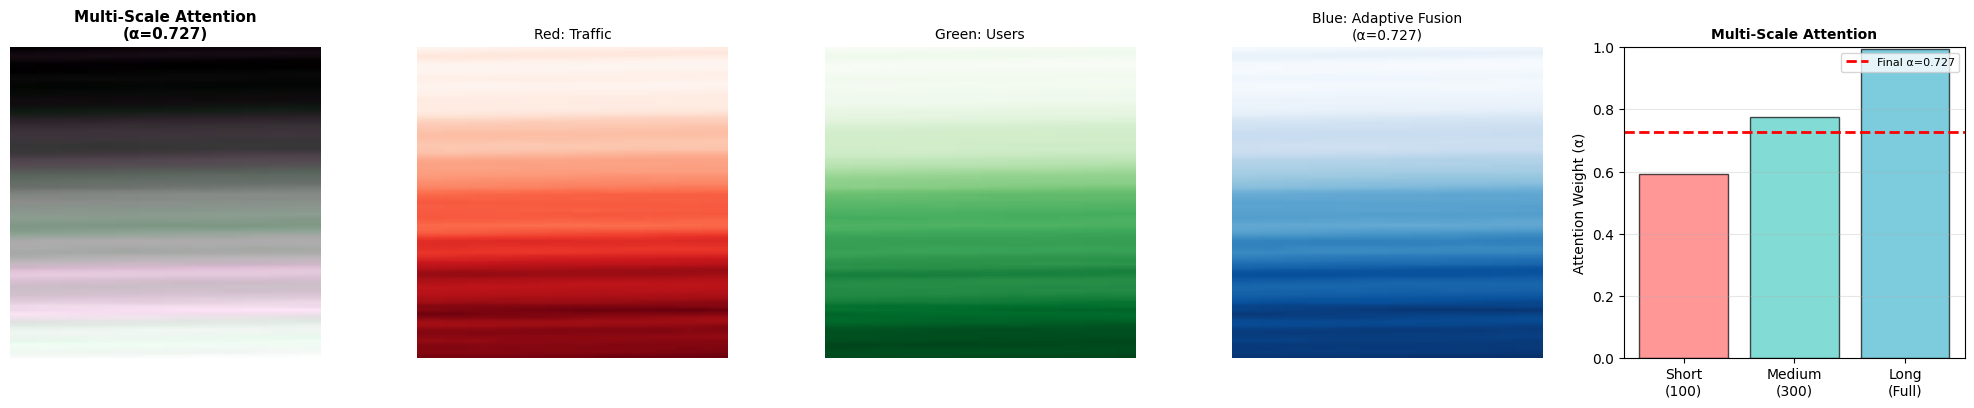

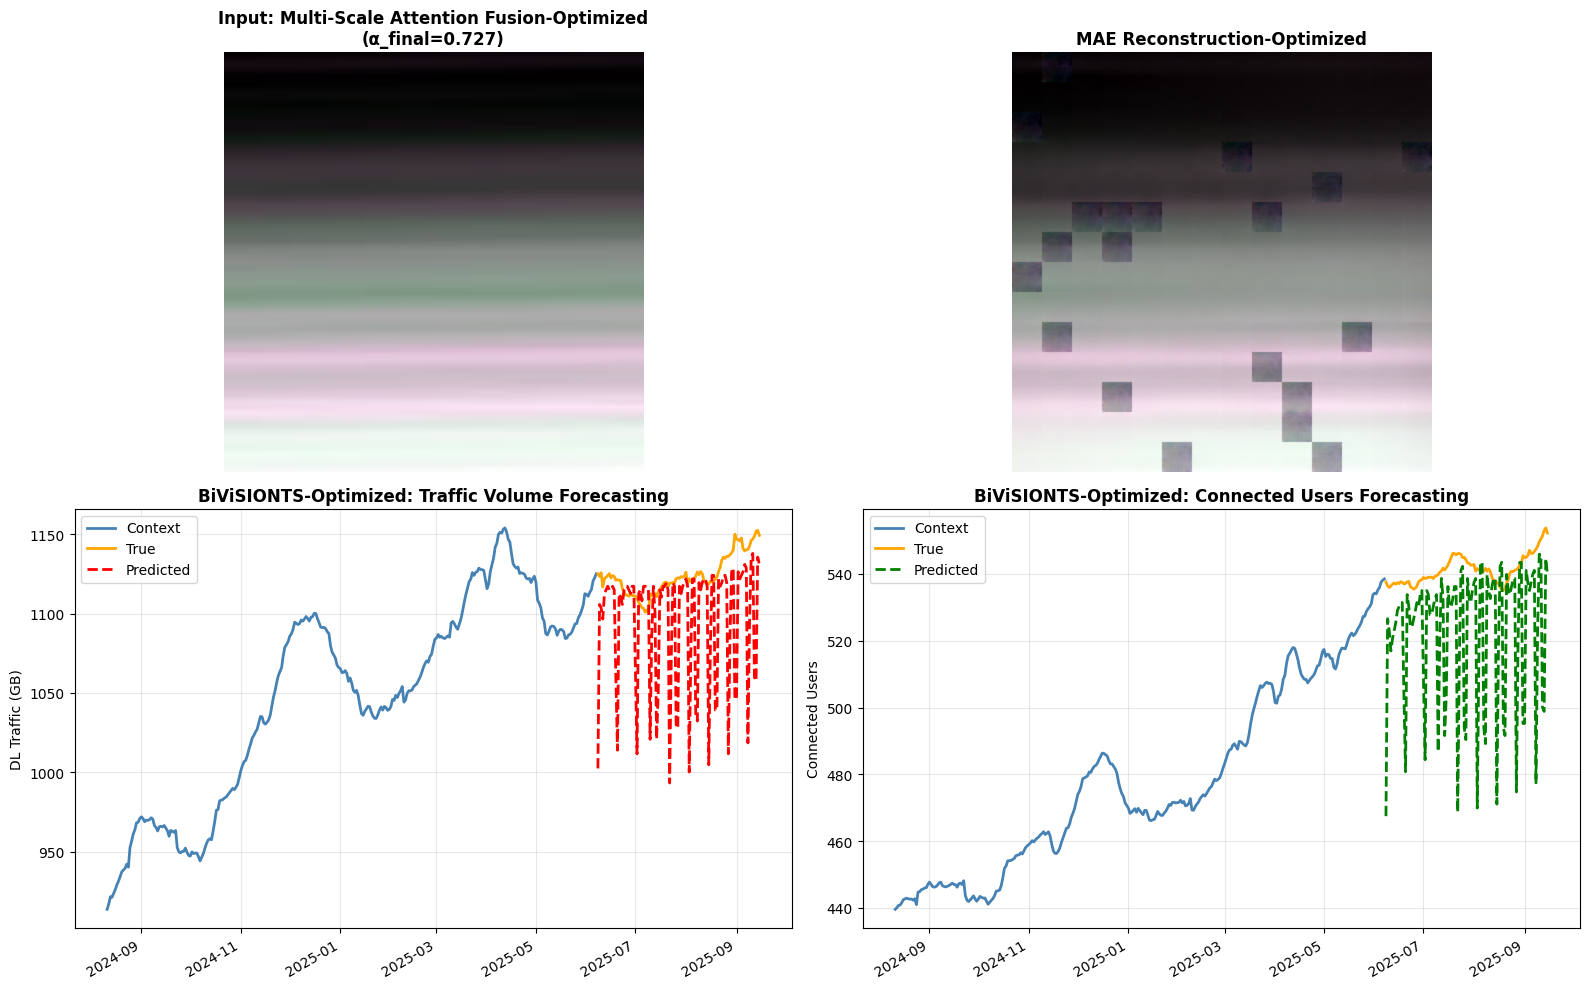

📊 BiViSIONTS-OPTIMIZED Evaluation (Multi-Scale Attention)

🏆 Hyperparameters:
  Mask Ratio: 0.9
  Periodicity: 12
  Short Window: 150
  Medium Window: 200

🎯 Multi-Scale Attention Parameters:
  Short-term: ρ=0.1831 → α=0.5916 (weight: 0.5)
  Medium-term: ρ=0.5487 → α=0.7743 (weight: 0.3)
  Long-term: ρ=0.9896 → α=0.9948 (weight: 0.2)
  ⚡ Final Attention α: 0.7270

🔴 DL Traffic Volume:
  MSE  = 2409.8505
  MAE  = 30.6806
  RMSE = 49.0902
  ✅ Success Rate (±10%): 94.00%

🟢 Connected Users:
  MSE  = 775.3671
  MAE  = 18.7425
  RMSE = 27.8454
  ✅ Success Rate (±10%): 92.00%

🎯 Overall Performance:
  Average Success Rate: 93.00%


In [44]:
# Initialize models & data
model, mae_model, full_traffic, full_users = initialize_models_and_data(data_traffic, data_users, CONTEXT_LEN, PRED_LEN, DEVICE)

print("🏆 OPTIMIZED CONFIGURATION")
print("=" * 80)
print(f"Mask Ratio: {OPTIMIZED_MASK_RATIO}")
print(f"Periodicity: {OPTIMIZED_PERIODICITY}")
print(f"Short Window: {OPTIMIZED_SHORT_WINDOW}")
print(f"Medium Window: {OPTIMIZED_MEDIUM_WINDOW}")
print("=" * 80)
print()

# Run forecast
result = run_bivisionts_multiscale_forecast(
    data_traffic, data_users, mae_model,
    CONTEXT_LEN, PRED_LEN,
    mask_ratio   =OPTIMIZED_MASK_RATIO   ,
    periodicity  =OPTIMIZED_PERIODICITY  ,
    short_window =OPTIMIZED_SHORT_WINDOW ,
    medium_window=OPTIMIZED_MEDIUM_WINDOW,
    device       =DEVICE
)

# Visualize encoding
visualize_multiscale_encoding(result['input_img'], result['norm_params'])

# Visualize forecast
visualize_forecast_results(result, df, CONTEXT_LEN, PRED_LEN, PLOT_CONTEXT_LEN, title_suffix="-Optimized")

# Print metrics
hyperparams = {
    'Mask Ratio'   : OPTIMIZED_MASK_RATIO   ,
    'Periodicity'  : OPTIMIZED_PERIODICITY  ,
    'Short Window' : OPTIMIZED_SHORT_WINDOW ,
    'Medium Window': OPTIMIZED_MEDIUM_WINDOW
}
print_metrics(result, hyperparams, "BiViSIONTS-OPTIMIZED Evaluation (Multi-Scale Attention)")

### Iterative Run

🔍 Testing Multi-Scale Attention with default parameters...
📊 Multi-Scale Correlations:
  Short-term (last 100): ρ=0.7643, α=0.8821 (weight: 0.5)
  Medium-term (last 300): ρ=0.8165, α=0.9083 (weight: 0.3)
  Long-term (full): ρ=0.9894, α=0.9947 (weight: 0.2)
  ⚡ Final Attention α: 0.9125

📊 Multi-Scale Correlations:
  Short-term (last 100): ρ=0.7643, α=0.8821
  Medium-term (last 300): ρ=0.8165, α=0.9083
  Long-term (full): ρ=0.9894, α=0.9947
  ⚡ Final Attention α: 0.9125


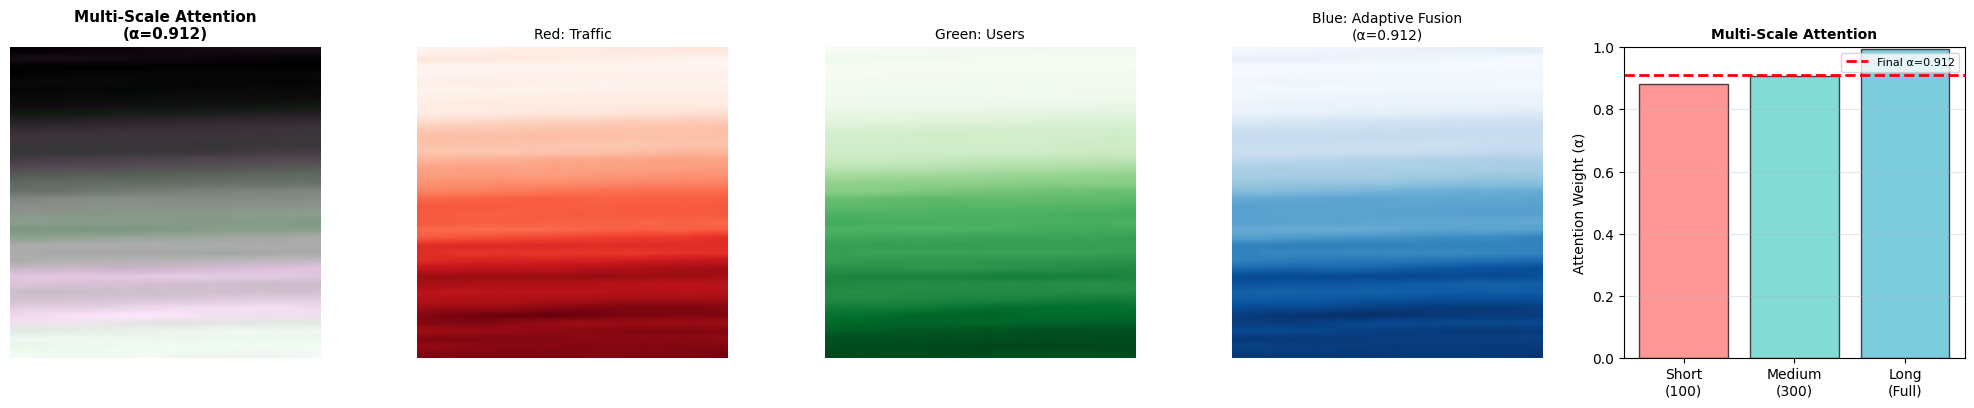

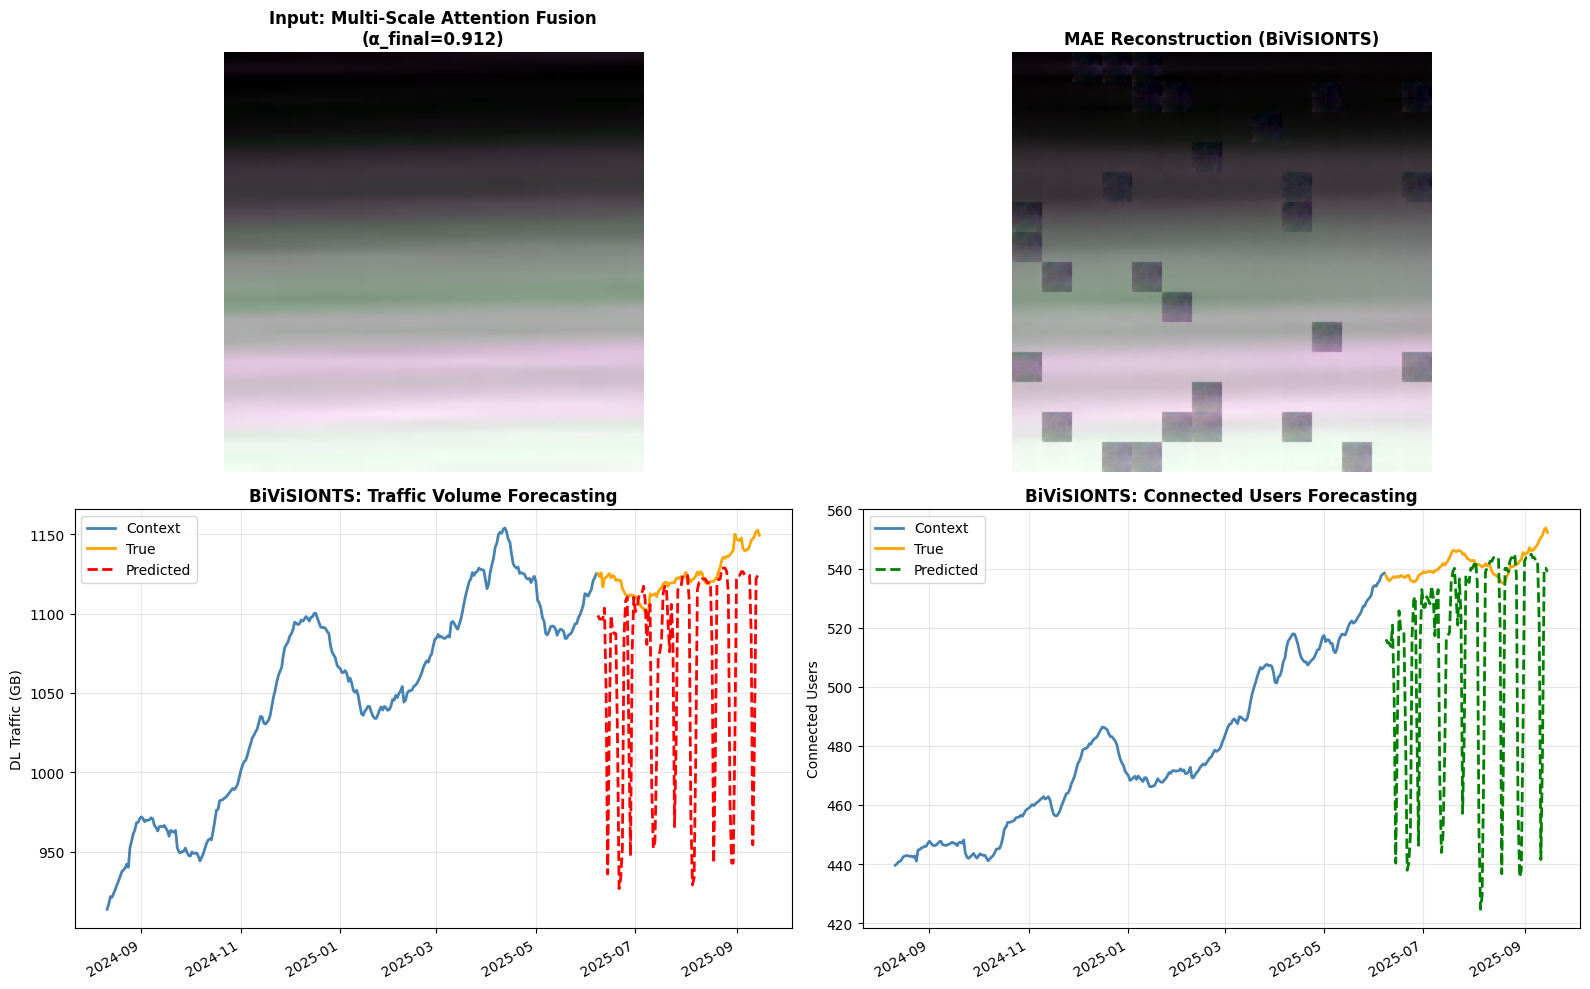


📊 BiViSIONTS Initial Test - Multi-Scale Attention-Weighted Fusion

🎯 Multi-Scale Attention Parameters:
  Short-term: ρ=0.7643 → α=0.8821 (weight: 0.5)
  Medium-term: ρ=0.8165 → α=0.9083 (weight: 0.3)
  Long-term: ρ=0.9894 → α=0.9947 (weight: 0.2)
  ⚡ Final Attention α: 0.9125

🔴 DL Traffic Volume:
  MSE  = 6576.8099
  MAE  = 51.2040
  RMSE = 81.0975
  ✅ Success Rate (±10%): 79.00%

🟢 Connected Users:
  MSE  = 2061.7579
  MAE  = 29.2930
  RMSE = 45.4066
  ✅ Success Rate (±10%): 77.00%


🔧 Starting Hyperparameter Optimization for Multi-Scale Attention...
Total combinations to test: 108

📊 Multi-Scale Correlations:
  Short-term (last 50): ρ=0.2517, α=0.6259 (weight: 0.5)
  Medium-term (last 200): ρ=0.5487, α=0.7743 (weight: 0.3)
  Long-term (full): ρ=0.9896, α=0.9948 (weight: 0.2)
  ⚡ Final Attention α: 0.7442
📊 Multi-Scale Correlations:
  Short-term (last 50): ρ=0.2517, α=0.6259 (weight: 0.5)
  Medium-term (last 300): ρ=0.8228, α=0.9114 (weight: 0.3)
  Long-term (full): ρ=0.9896, α=0.99

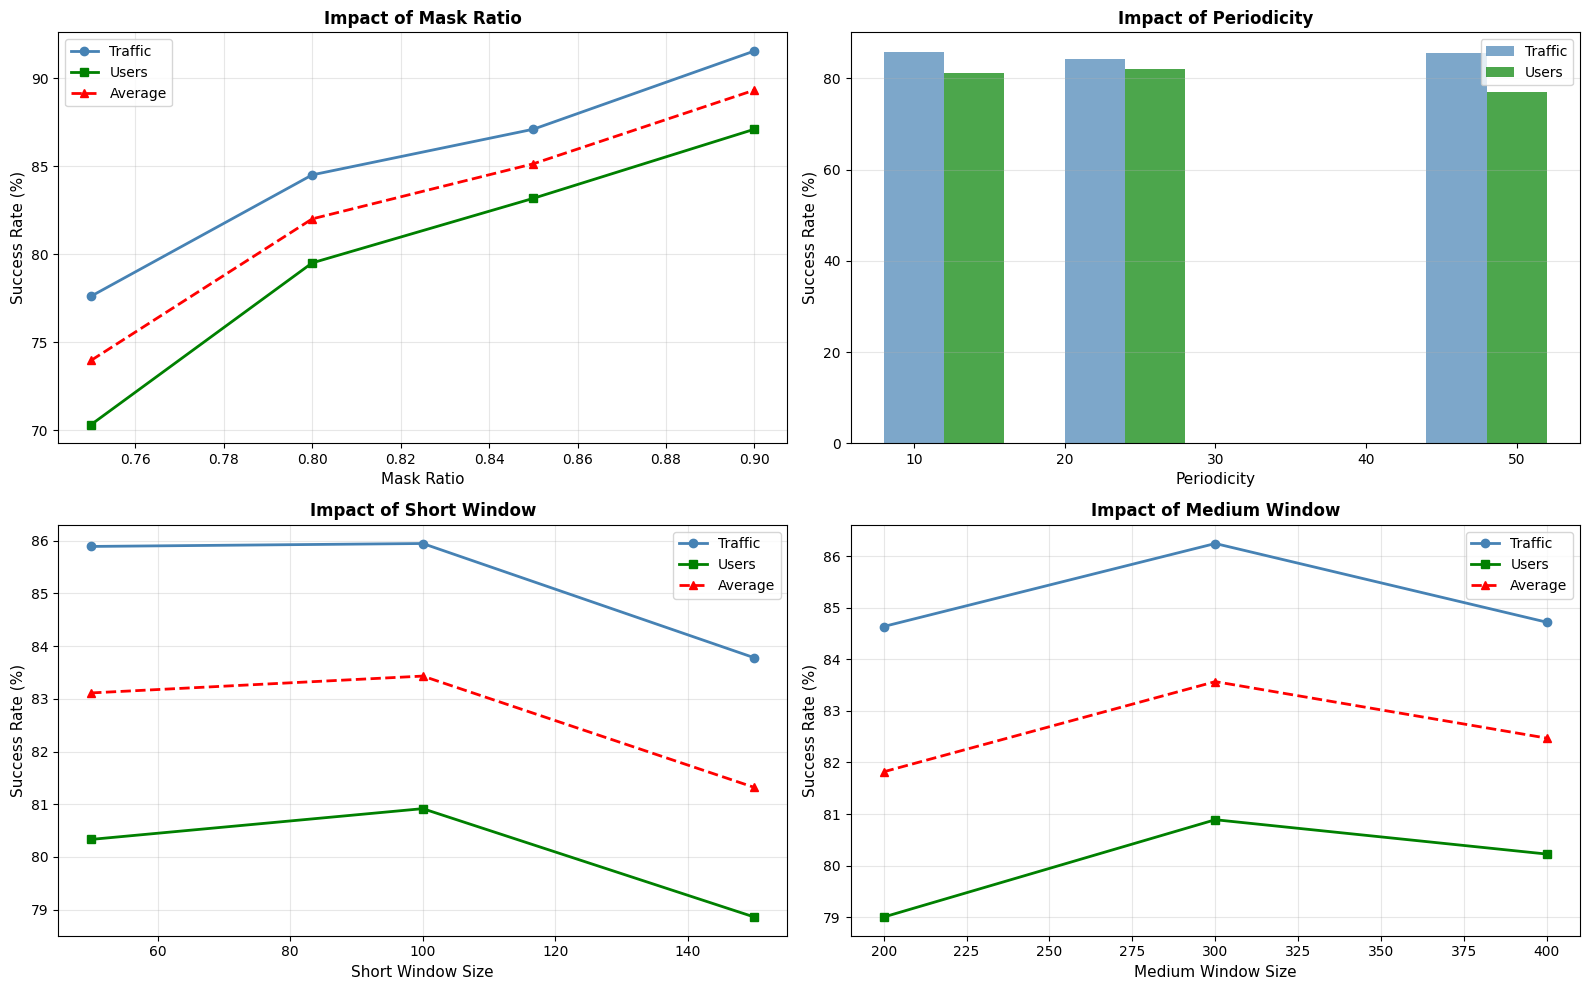


💾 Results saved to 'hyperparameter_optimization_results.csv'


STARTING CONVERGENCE ANALYSIS WITH OPTIMIZED PARAMETERS

🔄 Running Multi-Scale Attention with BEST parameters (500 iterations)...
Best Configuration:
  Mask Ratio: 0.9
  Periodicity: 12
  Short Window: 150
  Medium Window: 200

📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.1831, α=0.5916 (weight: 0.5)
  Medium-term (last 200): ρ=0.5487, α=0.7743 (weight: 0.3)
  Long-term (full): ρ=0.9896, α=0.9948 (weight: 0.2)
  ⚡ Final Attention α: 0.7270
📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.1831, α=0.5916 (weight: 0.5)
  Medium-term (last 200): ρ=0.5487, α=0.7743 (weight: 0.3)
  Long-term (full): ρ=0.9896, α=0.9948 (weight: 0.2)
  ⚡ Final Attention α: 0.7270
📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.1831, α=0.5916 (weight: 0.5)
  Medium-term (last 200): ρ=0.5487, α=0.7743 (weight: 0.3)
  Long-term (full): ρ=0.9896, α=0.9948 (weight: 0.2)
  ⚡ Final Attention α: 0.7270
📊 Multi-Scale Correlatio

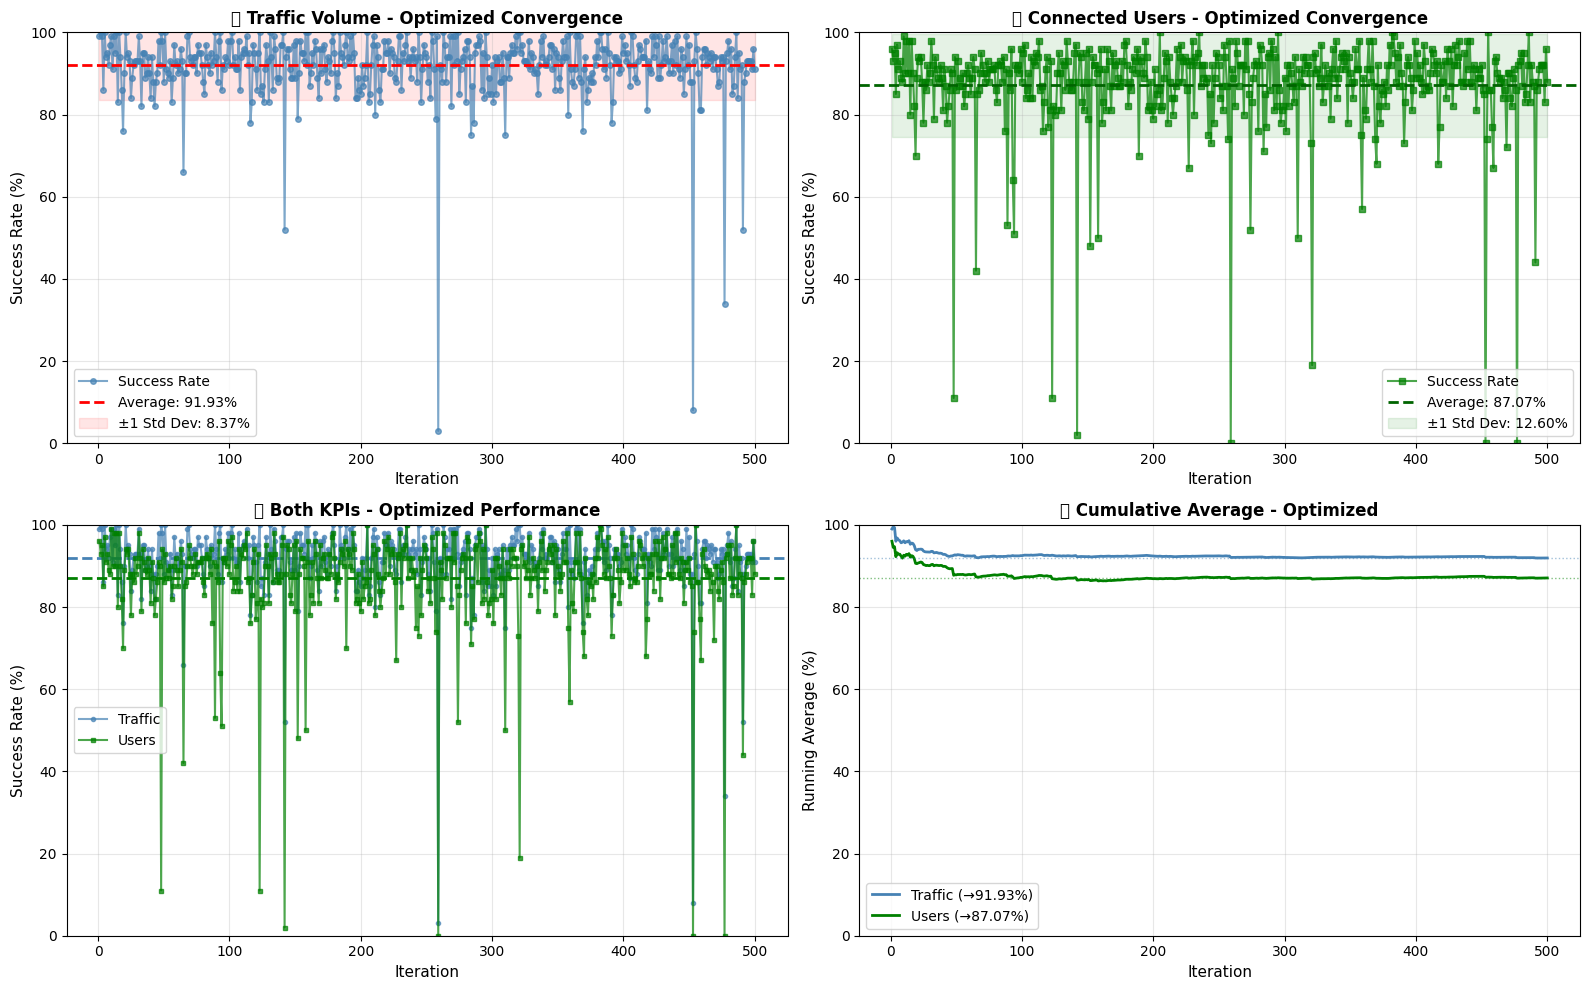

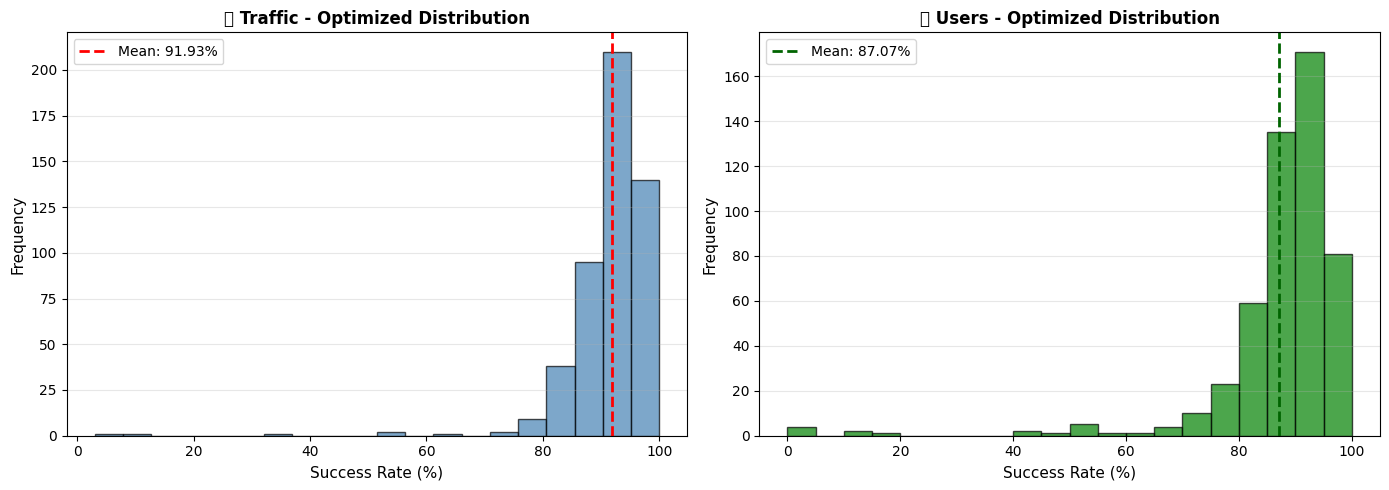



🎉 COMPLETE: Multi-Scale Attention BiViSIONTS with Full Optimization

📈 FINAL RESULTS:
  🔴 Traffic: 91.93% ± 8.37%
  🟢 Users: 87.07% ± 12.60%
  🎯 Overall: 89.50%


In [46]:
# Initialize models & data
model, mae_model, full_traffic, full_users = initialize_models_and_data(data_traffic, data_users, CONTEXT_LEN, PRED_LEN, DEVICE)

# ========================================================================
# PART 1: Initial Test with Default Parameters
# ========================================================================
run_initial_test(mae_model, full_traffic, full_users, CONTEXT_LEN, PRED_LEN, x_traffic, y_traffic, x_users, y_users, PLOT_CONTEXT_LEN, df, DEVICE)

# ========================================================================
# PART 2: Hyperparameter Optimization Grid Search
# ========================================================================
best_config = run_hyperparameter_optimization(mae_model, full_traffic, full_users, CONTEXT_LEN, PRED_LEN, DEVICE)

# ========================================================================
# PART 3: Multi-Iteration Convergence Analysis with Best Parameters
# ========================================================================
traffic_success_rates, users_success_rates = run_convergence_analysis(mae_model, full_traffic, full_users, CONTEXT_LEN, PRED_LEN, best_config, NUM_ITERATIONS, DEVICE)

# ========================================================================
# Final Summary
# ========================================================================
print_final_summary(traffic_success_rates, users_success_rates)